# Introduction

In this notebook, we demonstrate the use of Prototypical Network model from `tensorflow-fewshot`. We use the Omniglot dataset as an example, and we aim to replicate the results claimed in the paper that introduced Prototypical Networks: *Prototpical Networks for Few-shot Learning* (Snell et al., 2017).

## Imports

In [1]:
import os
import sys

In [2]:
from tensorflow_fewshot.models import PrototypicalNetwork
import tensorflow_fewshot.models.utils as utils
from tensorflow_fewshot.datasets import MetaDatasetFromArray, 

In [3]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from skimage.transform import resize
from skimage.color import rgb2gray

import tensorflow_datasets as tfds

from IPython.display import display, clear_output

## Dataset loading and preprocessing

In [4]:
# Load Omniglot using tensorflow datasets. It provides standard train/test splits out of the box.
train_ds = tfds.load("omniglot", split=tfds.Split.TRAIN, batch_size=-1)
################################
# We construct the actual training set by taking the first channel (they are all equal), resizing
# the images to 28x28, and inverting the colors so that the actual signal is positive while black
# pixels are zeroed out. Finally we rescale the image to the range [0, 1] for numerical stability.
# The resulting dataset is then augmented with 90°, 180° and 270° rotations.
#
# Downscaling is important, otherwise the network isn't powerful enough to train
################################
omniglot_X = tfds.as_numpy(train_ds)['image'].astype(np.float32)
train_X = np.zeros((4 * omniglot_X.shape[0], 28, 28, 1), dtype=np.float32)
train_Y = tfds.as_numpy(train_ds)['label']
train_Y = np.tile(train_Y, 4) + np.repeat([0, 1, 2, 3], train_Y.shape[0]) * np.max(train_Y)
resize_batch_size = 256
# Batch transformation
for i in range(omniglot_X.shape[0] // resize_batch_size):
    if i % 1 == 0:
        clear_output(wait=True)
        display('resize + grayscale: ' + str(i * 100 // (omniglot_X.shape[0] // resize_batch_size)) + '%')
    train_X[i * resize_batch_size:(i + 1) * resize_batch_size, :, :, :] = resize(
        (
            (255 - omniglot_X[i * resize_batch_size:(i + 1) * resize_batch_size, :, :, 0])/255
        )[:, :, :, None],
        (resize_batch_size, 28, 28, 1)
    )

# Remaining elements
train_X[-(omniglot_X.shape[0] % resize_batch_size): :, :, :] = resize(
        (
            (255 - omniglot_X[-(omniglot_X.shape[0] % resize_batch_size):, :, :, 0])/255
        )[:, :, :, None],
        (omniglot_X.shape[0] % resize_batch_size, 28, 28, 1))

# Adding all 4 rotations to training data
for i in range(omniglot_X.shape[0] // resize_batch_size):
    clear_output(wait=True)
    display('rotations ' + str(i * 100 // (omniglot_X.shape[0] // resize_batch_size)) + '%')
    for rot in [1, 2, 3]:
        train_X[
            omniglot_X.shape[0] * rot + i * resize_batch_size:
            omniglot_X.shape[0] * rot + (i + 1) * resize_batch_size,
            :, :, :
        ] = np.rot90(train_X[
                     i * resize_batch_size:(i + 1) * resize_batch_size, :, :, :
                     ], rot, (1, 2))
for rot in [1, 2, 3]:
    train_X[
        rot * omniglot_X.shape[0] - (omniglot_X.shape[0] % resize_batch_size):rot * omniglot_X.shape[0],
        :, :, :
    ] = np.rot90(train_X[
                     - (omniglot_X.shape[0] % resize_batch_size):, :, :, :
                 ], rot, (1, 2))

# Apply the same transformations to the test set
test_ds = tfds.load("omniglot", split=tfds.Split.TEST, batch_size=-1)
omniglot_test_X = tfds.as_numpy(test_ds)['image'].astype(np.float32)
test_X = np.zeros((omniglot_test_X.shape[0], 28, 28, 1), dtype=np.float32)
test_Y = tfds.as_numpy(test_ds)['label']
for i in range(test_X.shape[0] // resize_batch_size):
    if i % 1 == 0:
        clear_output(wait=True)
        display('Test set ' + str(i * 100 // (test_X.shape[0] // resize_batch_size)) + '%')
    test_X[i * resize_batch_size:(i + 1) * resize_batch_size, :, :, :] = resize(
        (
            (255 - omniglot_test_X[i * resize_batch_size:(i + 1) * resize_batch_size, :, :, 0])/255
        )[:, :, :, None],
        (resize_batch_size, 28, 28, 1))

test_X[-(omniglot_test_X.shape[0] % resize_batch_size): :, :, :] = resize(
        (
            (255 - omniglot_test_X[-(omniglot_test_X.shape[0] % resize_batch_size):, :, :, 0])/255
        )[:, :, :, None],
        (omniglot_test_X.shape[0] % resize_batch_size, 28, 28, 1))

# Display the split
print("Train X shape:", train_X.shape)
print("Train Y shape:", train_Y.shape)
print("Test X shape:", test_X.shape)
print("Test Y shape:", test_Y.shape)

'Test set 98%'

Train X shape: (77120, 28, 28, 1)
Train Y shape: (77120,)
Test X shape: (13180, 28, 28, 1)
Test Y shape: (13180,)


Exemples de classes, avec 5 représentants chacune


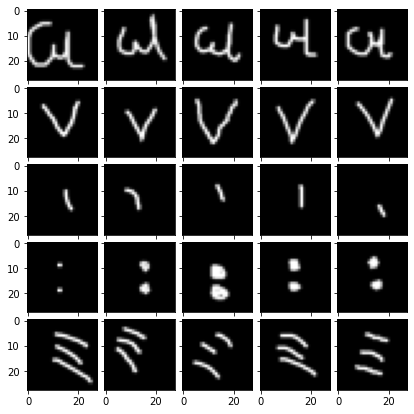

In [5]:
# Display the dataset on a Grid
# np.random.choice(class_name, 5)
classes_to_draw = [453, 837, 278, 192, 625]
indices_to_draw = []
for class_id in classes_to_draw:
    class_indices = np.array(
    list(filter(lambda elem: elem[1] == class_id, enumerate(train_Y)))
    )
    chosen_examples_indices = np.random.choice(range(len(class_indices)), 5)
    indices_to_draw.extend(class_indices[chosen_examples_indices,:])

fig = plt.figure(figsize=(7., 7.))
print("Exemples de classes, avec 5 représentants chacune")
grid = ImageGrid(
    fig, 111,
    nrows_ncols=(len(classes_to_draw), 5),
    axes_pad=0.1,
)

for ax, im in zip(grid, indices_to_draw):
    # Iterating over the grid returns the Axes.
    ax.imshow(train_X[im[0],:,:,0], cmap='gray')

Here, each task corresponds to the classification of a limited set of characters. We will use 5 of them in the rest of this notebook. We thus talk about 5-way classification.
The model will be meta-trained on randomly-generated 5-way classification tasks, and then evaluated on tasks sampled from **unseen** characters (from the test set).

In [5]:
meta_train_ds = MetaDatasetFromArray(train_X, train_Y)

## Meta-training

The encoder we will be using is one proposed by Vinyals et al. in their 2016 paper "Matching Networks for One Shot Learning".

In [6]:
encoder = utils.create_standardized_CNN(input_shape=(28, 28, 1))

In [7]:
protonet = PrototypicalNetwork(encoder=encoder)

The encoder returns 64-dimensional embeddings. For instance, if we feed the network 5 images from our data set, we get a (5, 64)-sized tensor.

In [8]:
protonet.encoder(test_X[200:205,:,:,:]).shape

TensorShape([5, 64])

The meta-training hyper-parameters match those proposed in the original paper for Prototypical Networks:
- We sample 5 tasks consisting of 5 different characters to classify
- For each character, 5 images are used as the support set to create the class embedding
- For each character, 5 images are used as the query set, to compute the loss function and backpropagate the gradient through the encoder

In [9]:
n_episode = 2000
n_way = 5
ks_shot = 5
kq_shot = 5
learning_rate = 1e-3

def task_generator():
    n_task = 32
    for task in range(n_task):
        yield meta_train_ds.get_one_episode(n_way=5, ks_shot=5, kq_shot=5)

def episode_end_callback(**kwargs):
    n_episode = kwargs['episode']
    if n_episode%100 == 0:
        epi_loss = kwargs['episode_loss'].numpy()
        print("At episode", n_episode, "episode loss is", epi_loss)

In [10]:
protonet.meta_train(
    task_generator,
    n_episode=n_episode,
    n_way=n_way,
    ks_shots=ks_shot,
    kq_shots=ks_shot,
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    episode_end_callback=episode_end_callback
)

At episode 0 episode loss is 39.766712
At episode 100 episode loss is 3.434962
At episode 200 episode loss is 12.811996
At episode 300 episode loss is 16.434214
At episode 400 episode loss is 2.2627409
At episode 500 episode loss is 4.534413
At episode 600 episode loss is 2.2596307
At episode 700 episode loss is 8.590659
At episode 800 episode loss is 0.51724035
At episode 900 episode loss is 0.87326676
At episode 1000 episode loss is 4.5034046
At episode 1100 episode loss is 2.5264752
At episode 1200 episode loss is 2.9225144
At episode 1300 episode loss is 3.1530998
At episode 1400 episode loss is 0.24291024
At episode 1500 episode loss is 0.5247797
At episode 1600 episode loss is 0.23270082
At episode 1700 episode loss is 0.97202617
At episode 1800 episode loss is 2.5867794
At episode 1900 episode loss is 0.8325193


## Example of fine-tuning and prediction
Here we sample five characters that would be unseen examples in a real world setting. We fine tune our model on those 25 images (5-way 5-shot) and make predictions.

In [19]:
test_classes = np.random.choice(np.unique(test_Y), size=5, replace=False)
print("Test classes are:", test_classes)

fit_indices = np.zeros((25,), dtype=np.int32)
test_indices = np.zeros((25,), dtype=np.int32)
for i in range(5):
    class_indices = np.random.choice(
        np.argwhere(test_Y == test_classes[i]).flatten(),
        size=10,
        replace=False
    )
    fit_indices[i*5:(i+1)*5] = class_indices[:5]
    test_indices[i*5:(i+1)*5] = class_indices[5:]

fit_data = test_X[fit_indices,:,:,:]
fit_labels = test_Y[fit_indices]

test_data = test_X[test_indices,:,:,:]
test_labels = test_Y[test_indices]

Test classes are: [1496 1268 1379 1437 1266]


In [20]:
protonet.fit(fit_data.astype(np.float32), fit_labels)

In [21]:
test_preds = protonet.predict(test_data)

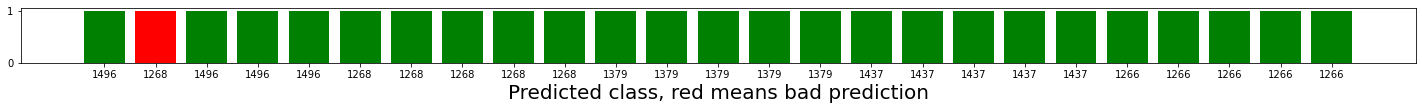

In [23]:
plt.figure(figsize=(25, 1))
plt.bar(np.arange(len(test_labels)), (test_preds==test_labels).astype(np.int), color='g', tick_label=test_preds)
plt.bar(np.arange(len(test_labels)), (test_preds!=test_labels).astype(np.int), color='r', tick_label=test_preds)
plt.xlabel("Predicted class, red means bad prediction", size=20);

## Evaluation

In [24]:
eval_ds = MetaDatasetFromArray(test_X, test_Y)

In [28]:
n_task = 1000

acc = []
for i_task in range(n_task):
    clear_output(wait=True)
    display("Evaluation task "+str(i_task+1)+" out of "+str(n_task))
    train_set, eval_set = eval_ds.get_one_episode(n_way=5, ks_shot=5, kq_shot=5)
    protonet.fit(train_set[0], train_set[1])
    eval_preds = protonet.predict(eval_set[0])
    acc.append(np.mean(eval_preds == eval_set[1]))

'Evaluation task 1000 out of 1000'

In [29]:
mean_acc = np.mean(acc)
var = np.var(acc)
ic95 = 1.96*np.sqrt(var/n_task)
print("Accuracy on", n_task, "randomly sampled tasks is", str(round(mean_acc*100, 2))+"%", "+/-", round(ic95*100, 2))

Accuracy on 1000 randomly sampled tasks is 96.08% +/- 0.32
